In [1]:
!pip install torch torchvision opencv-python matplotlib pandas

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [3]:
import torch

class AnimalDataset(Dataset):
    def __init__(self, data_dir, csv_path, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.labels = []
        self.bboxes = []
        self.image_paths = []
        self.diet_info = pd.read_csv(csv_path)  # Read dietary info (carnivore or not)
        
        # Create a list of all unique animal names
        self.animal_classes = sorted(list(set()))  # Initialize as empty list to be updated below
        self.name_to_idx = {}

        # Iterate through all folders and labels to get unique animal names
        self._prepare_data()

    def _prepare_data(self):
        # Iterate through all animal folders
        for animal_folder in os.listdir(self.data_dir):
            animal_path = os.path.join(self.data_dir, animal_folder)
            if not os.path.isdir(animal_path):
                continue

            label_path = os.path.join(animal_path, "Label")
            for label_file in os.listdir(label_path):
                label_file_path = os.path.join(label_path, label_file)
                image_name = label_file.replace(".txt", ".jpg")
                image_path = os.path.join(animal_path, image_name)

                with open(label_file_path, "r") as f:
                    lines = f.readlines()
                    for line in lines:
                        line_parts = line.strip().split()
                        # Extract the name which could be multiple words
                        name = ' '.join(line_parts[:-4])  # Everything except the last 4 values (bounding box coordinates)
                        bbox = list(map(float, line_parts[-4:]))  # Last 4 values are bounding box coordinates

                        # Add to animal classes list
                        if name not in self.animal_classes:
                            self.animal_classes.append(name)

                        # Map the name to the class index
                        label_idx = self.animal_classes.index(name)
                        self.labels.append(label_idx)
                        self.bboxes.append(bbox)
                        self.image_paths.append(image_path)

        # Create a mapping from animal names to numeric indices
        self.name_to_idx = {name: idx for idx, name in enumerate(self.animal_classes)}

        # Optionally, save this mapping for later reference
        # with open('animal_name_to_idx.json', 'w') as f:
        #     json.dump(self.name_to_idx, f)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = self.labels[idx]
        bbox = torch.tensor(self.bboxes[idx], dtype=torch.float32)  # Convert bounding boxes to tensor
        
        # Find carnivore info
        is_carnivore = int(
            self.diet_info[self.diet_info["name"] == self.animal_classes[label]]["carnivore"].values[0]
        )

        if self.transform:
            image = self.transform(image)

        # Convert image and label to tensor as well
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label, bbox, is_carnivore


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# # Define your model architecture (example architecture)
# class AnimalDetectionModel(nn.Module):
#     def __init__(self, num_classes):
#         super(AnimalDetectionModel, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(32*64*64, 128)
#         self.fc2 = nn.Linear(128, num_classes + 4)  # num_classes for classification and 4 for bbox prediction

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x


class AnimalDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(AnimalDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)   
        # After pooling, spatial size is reduced to 56x56
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes + 4)  # num_classes for classification and 4 for bbox prediction
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)  # Apply pooling
        x = torch.relu(self.conv2(x))
        x = self.pool(x)  # Apply pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [6]:
num_epochs = 5
batch_size = 64
learning_rate = 0.001
num_classes = 80  # Assuming you have 21 folders for 21 animal classes

In [7]:
# train_data = AnimalDataset("/kaggle/input/animals-detection-images-dataset/train", "/kaggle/input/diet-of-animals/diet_info.csv", transform=transform)
# train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
train_dataset = AnimalDataset("/kaggle/input/animals-detection-images-dataset/train", "/kaggle/input/diet-of-animals/diet_info.csv", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
num_classes = 80  # Number of animals
model = AnimalDetectionModel(num_classes).cuda()  # Move model to GPU if available
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
model = AnimalDetectionModel(num_classes=num_classes).cuda()  # Move model to GPU
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, labels, bboxes, is_carnivore in train_loader:
        images = images.cuda()  # Move data to GPU
        labels = labels.cuda()  # Move labels to GPU
        bboxes = bboxes.cuda()  # Move bounding boxes to GPU

        outputs = model(images)
        cls_preds, bbox_preds = outputs[:, :num_classes], outputs[:, num_classes:]

        # Calculate the classification loss (cross-entropy)
        loss_cls = criterion(cls_preds, labels)

        # Calculate bounding box regression loss (MSE)
        loss_bbox = torch.mean((bbox_preds - bboxes) ** 2)

        # Total loss
        loss = loss_cls + loss_bbox

        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

<ipython-input-3-f3dd81996fa0>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Epoch [1/5], Loss: 19472752.0332
Epoch [2/5], Loss: 15181143.0781
Epoch [3/5], Loss: 14275110.7422
Epoch [4/5], Loss: 13409369.1016
Epoch [5/5], Loss: 12843020.8203


In [18]:
# Save after training
torch.save(model.state_dict(), "/kaggle/working/final_model.pth")

In [14]:
test_dataset = AnimalDataset("/kaggle/input/animals-detection-images-dataset/test", "/kaggle/input/diet-of-animals/diet_info.csv", transform=transform)

In [15]:
from torch.utils.data import DataLoader

val_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # Shuffling is unnecessary for evaluation
    num_workers=4,  # Adjust based on your system
    pin_memory=True
)

In [16]:
# Evaluation loop
from sklearn.metrics import accuracy_score

model.eval()  # Set model to evaluation mode
all_labels = []
all_cls_preds = []

with torch.no_grad():  # Disable gradient computation
    total_loss = 0
    total_samples = 0
    
    for images, labels, bboxes, is_carnivore in val_loader:
        images = images.cuda()  # Move data to GPU
        labels = labels.cuda()  # Move labels to GPU
        bboxes = bboxes.cuda()  # Move bounding boxes to GPU
        
        # Forward pass
        outputs = model(images)
        cls_preds, bbox_preds = outputs[:, :num_classes], outputs[:, num_classes:]
        
        # Calculate classification loss
        loss_cls = criterion(cls_preds, labels)
        
        # Calculate bounding box regression loss (MSE)
        loss_bbox = torch.mean((bbox_preds - bboxes) ** 2)
        
        # Total loss
        loss = loss_cls + loss_bbox
        total_loss += loss.item()
        
        # Track classification predictions for accuracy
        _, predicted_labels = torch.max(cls_preds, 1)  # Get the class index with the highest score
        all_labels.extend(labels.cpu().numpy())  # Collect true labels
        all_cls_preds.extend(predicted_labels.cpu().numpy())  # Collect predicted labels
        
        total_samples += images.size(0)
    
    # Calculate accuracy for classification
    accuracy = accuracy_score(all_labels, all_cls_preds)
    
    # Report losses and accuracy
    avg_loss = total_loss / total_samples
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")


<ipython-input-3-f3dd81996fa0>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-3-f3dd81996fa0>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-3-f3dd81996fa0>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-3-f3dd81996fa0>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

Validation Loss: 572.0352
Classification Accuracy: 4.92%


In [17]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.7/450.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.4/130.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 91.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: hugging

In [25]:
import gradio as gr

# Define a simple file uploader for videos or images
def file_uploader(file):
    return f"File uploaded: {file.name}"

# Create a Gradio interface
interface = gr.Interface(
    fn=file_uploader, 
    inputs=gr.File(file_types=["image", "video"]), 
    outputs="text", 
    title="File Uploader"
)

# Launch the app
interface.launch()

* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://eaa2536fbbd748e70b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [20]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Function to preprocess the input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to match input size of the model
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
    ])
    image = Image.open(image_path).convert("RGB")  # Open image and ensure 3 channels (RGB)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to make predictions
def predict_image(image_path, model, num_classes):
    model.eval()  # Set model to evaluation mode
    image = preprocess_image(image_path).cuda()  # Preprocess and move image to GPU

    with torch.no_grad():  # Disable gradient computation
        outputs = model(image)
        cls_preds, bbox_preds = outputs[:, :num_classes], outputs[:, num_classes:]

        # Get the predicted class
        _, predicted_label = torch.max(cls_preds, 1)
        predicted_label = predicted_label.item()

        # Bounding box predictions
        bbox_preds = bbox_preds.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU

    return predicted_label, bbox_preds

# Path to the unknown image
unknown_image_path = "/kaggle/input/animals-detection-images-dataset/test/Bear/23bf858cb1d0ef63.jpg"

# Load the trained model
model = AnimalDetectionModel(num_classes=num_classes).cuda()
model.load_state_dict(torch.load("/kaggle/working/final_model.pth"))

# Make predictions
predicted_class, predicted_bbox = predict_image(unknown_image_path, model, num_classes)

# Print predictions
print(f"Predicted Class: {predicted_class}")
print(f"Predicted Bounding Box: {predicted_bbox}")


Predicted Class: 52
Predicted Bounding Box: [264.72034 178.30336 733.06665 617.8627 ]


<ipython-input-20-436f82ade4f7>:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/final_model.pth"))


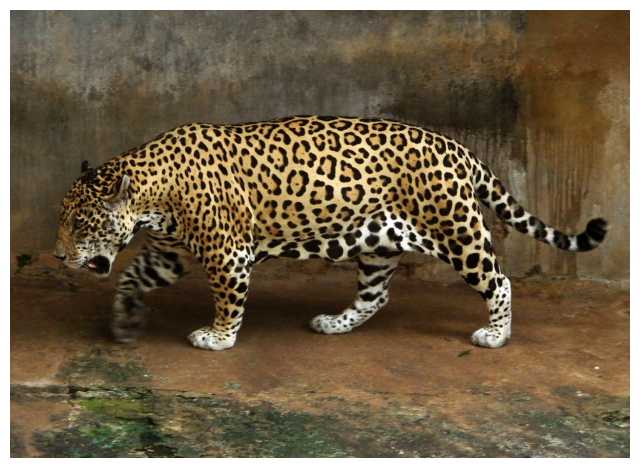

In [21]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to the image
unknown_image_path = "/kaggle/input/animals-detection-images-dataset/train/Cheetah/025d25975e4275a2.jpg"

# Open and display the image
image = Image.open(unknown_image_path)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")  # Turn off the axes
plt.show()


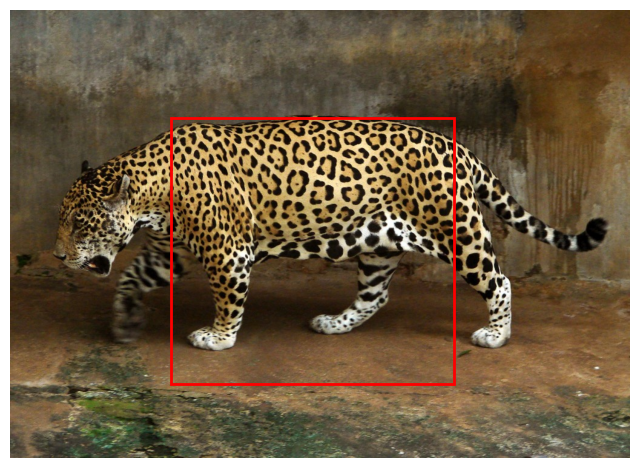

In [22]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to plot the image with the bounding box
def plot_image_with_bbox_only(image_path, bbox):
    # Open the image
    image = Image.open(image_path)
    
    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    
    # Draw the bounding box
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        plt.gca().add_patch(
            plt.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min, 
                fill=False, edgecolor="red", linewidth=2
            )
        )
    
    plt.show()

# Example usage
unknown_image_path = "/kaggle/input/animals-detection-images-dataset/train/Cheetah/025d25975e4275a2.jpg"

# Replace with actual prediction function
# Example bounding box coordinates

# Plot the image with the bounding box
plot_image_with_bbox_only(unknown_image_path, predicted_bbox)

In [26]:
import gradio as gr
from PIL import Image
import torchvision.transforms as transforms
import torch

# Function to preprocess the input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to match input size of the model
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
    ])
    image = Image.open(image_path).convert("RGB")  # Open image and ensure 3 channels (RGB)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to make predictions
def predict_image(image_path):
    model.eval()  # Set model to evaluation mode
    image = preprocess_image(image_path).cuda()  # Preprocess and move image to GPU

    with torch.no_grad():  # Disable gradient computation
        outputs = model(image)
        cls_preds, bbox_preds = outputs[:, :num_classes], outputs[:, num_classes:]

        # Get the predicted class
        _, predicted_label = torch.max(cls_preds, 1)
        predicted_label = predicted_label.item()

        # Bounding box predictions
        bbox_preds = bbox_preds.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU

    return f"Class: {predicted_label}", f"Bounding Box: {bbox_preds}"

# Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="filepath"),  # Input is an image file
    outputs=["text", "text"],  # Output predicted class and bounding box
    title="Animal Detection Model",
    description="Upload an image to predict the animal class and bounding box."
)

# Launch Gradio app
interface.launch()

* Running on local URL:  http://127.0.0.1:7861
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://1acabe6b2efd91c4d1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3437, in open
    fp.seek(0)
AttributeError: 'NoneType' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 2042, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1589, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asy